# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.utils import shuffle as sk_shuffler
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

Пусть есть функционал $$J(w) = \|Xw - y\|^2 = \langle Xw - y, Xw - y \rangle,$$ найдем его производную Фреше (для скалярного функционала она совпадает с градиентом). Для изменения аргумента $h$ приращение функционала равно
$$J(w+h) - J(w) = \langle X(w + h) - y, X(w + h) - y \rangle - \langle Xw - y, Xw - y \rangle = $$
$$ = \langle Xw + Xh - y, Xw + Xh - y \rangle - \langle Xw - y, Xw - y \rangle = $$
$$ = \langle Xh, Xh \rangle + \langle Xw - y, Xh \rangle + \langle Xh, Xw - y \rangle + \langle Xw - y, Xw - y \rangle - \langle Xw - y, Xw - y \rangle = $$
$$ = \| Xh \|^2 + \langle h, 2X^*(Xw - y) \rangle$$
Имеем
$$ J'(w) = \lim_{h \to 0} \frac{J(w+h) - J(w)}{h} = 2X^*(Xw - y).$$
Когда соблюдаются условия регулярности $X^* = X^T$ и получается почти как в лекции. На самом деле не почти, рассмотрим уравнение
$$2X^*Xw = 2X^*y,$$
разделим обе части на $2$ и умножим слева на $(X^*)^{-1}$, получим 
$$ Xw = y.$$
Таким образом, $w = X^{-1}y$ есть решение системы линейных уравнений. На практике скорее всего обратной матрицы не будет, и придется использовать псевдообратную.

Выберем начальную величину шага $\alpha_0$ и обозначим $\alpha_m$ величину шага спуска для $m$-й эпохи. Тогда формула обновления весов принимает следующий вид
$$w_{new} = w_{old} - \alpha_m \nabla L(w_{old}),$$
где 
$$L(w) = \frac{1}{N} \sum_{i=1}^N(\langle w_i,x_i \rangle - y_i)^2 + \frac{1}{C}\sum_{j=1}^N w_j^2.$$ 
Таким образом $$w_{new} = w_{old} - \alpha_m \nabla L(w_{old}) = $$
$$ = w_{old} - 2 \alpha_m \frac{1}{N} \sum_{i=1}^n (\langle w_{old}, x_i \rangle - y_i)x_i - 2 \alpha_m \frac{1}{C}\sum_{j=1}^n w_{old, j}.$$

Градиент с регуляризацией есть сумма двух векторов, один из которых направлен к вектору решений, второй в начало координат.

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

Пусть имеется набор объектов $X =\{x_i\}$, для которых необходимо определить принадлежность к множеству $A$. Положим
$$y_i = 𝟙(x_i \in A) = 
\begin{cases}
1, x_i \in A,\\
0, x_i \notin A,
\end{cases}$$
Функция потерь log loss имеет следующий вид
$$L(w) = -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(a_i) + (1 - y_i) \log(1 - a_i) \right) + \frac{1}{C}\sum_{j=1}^N w_j^2.$$
$$\nabla L(w) = - \frac{1}{N}\left( \frac{y_i}{\sigma(w, x_i)} - \frac{1 - y_i}{1-\sigma(w, x_i)} \right) \sigma'(w,x_i) + \frac{1}{C}\sum_{j=1}^n w_{old, j} = $$
$$ = - \frac{1}{N}\left( y_i(1 - \sigma(w, x_i)) - (1 - y_i)\sigma(w, x_i) \right)x_i + \frac{1}{C}\sum_{j=1}^n w_{old, j} = $$
$$ = \frac{1}{N}(\sigma(w, x_i) - y_i)x_i + \frac{1}{C}\sum_{j=1}^n w_{old, j}$$
$$w_{new} = w_{old} - \alpha_m \nabla L(w_{old}) = w_{old} - \alpha_m \left[\frac{1}{N} \sum_{i=1}^n ( a(x_i) - y_i)x_i + \frac{1}{C}\sum_{j=1}^n w_{old, j} \right]$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

Аналогично задаче 1 легко показать, что $J''(w) = 2X^*X$. Отсюда сразу получается неотрицательная определенность второй производной в силу свойства $X^*X \geqslant 0$ $(\forall w: \langle X^*Xw,w\rangle = \langle Xw,Xw\rangle = \| Xw \| ^2 \geqslant 0)$. Стоит отметить, что невырожденность $X^*$ существенна уже при вычислении первой производной, так как иначе получается тождество вида $0=0$.

Для регуляризированной модели
$$\nabla L(w) = \frac{1}{N} 2X^*(Xw-y) + \frac{1}{C}2w = 0 \Rightarrow$$
$$(\frac{1}{N} X^*X + \frac{1}{C}I)w = X^*Xy \Rightarrow$$
$$w = (\frac{1}{N}X^*X + \frac{1}{C}I)^{-1} X^*Xy,$$
Здесь $I$ --- единичная матрица, $C$ --- константа регуляризации.

Регуляризация помогает избежать проблемы линейно зависимых признаков в том, смысле, что линейно зависимые признаки с разными весами и регуляризацией перестают быть линейно зависимыми.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

Обозначим $a=a(x_i), a'=\frac{\partial a(x_i)}{\partial x_i}$, $p=p(y_i=1|x_i)$, тогда $p(y_i=0|x_i) = 1-p$ и 
$$\mathbb{E}(L|x_i) = -p \log a - (1-p) \log (1-a),$$
$$\frac{\partial \mathbb{E}(L|x_i)}{\partial a} = -\left( \frac{p}{a} - \frac{1-p}{1-a} \right)a',$$
точка экстремума $a=p$.
$$\frac{\partial^2 \mathbb{E}(L|x_i)}{\partial a^2}\bigg|_{a=p} = -\left(-\frac{1}{p}-\frac{1}{1-p}\right)(a')^2 + 0 a'' > 0,$$
получаем, что $a(x_i) = p(y_i=1|x_i)$ есть точка минимума функции.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

$w_0$ вводится в модель линейной регрессии для соответствия значения функционала в точке $f_i=0, i=1,..,k$ где $k$- количество признаков. При наложении регуляризации на $w_0$ мы, по сути, будем требовать занижения функционала в нуле, что не имеет практического смысла.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    # Нагенерим индексов, по которым будем дергать элементы выборки
    indices = np.arange(X.shape[0])
    if shuffle:
        indices = sk_shuffler(indices, random_state=0)

    for i in range(0, X.shape[0], batch_size):
        yield_ind = indices[i: i + batch_size]
        yield X[yield_ind], y[yield_ind]

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [7]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    # Your code Here
    return 1 / (1 + np.exp(-x))


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=10, alpha=0.01, max_epoch=10,
                 model_type='lin_reg', batch_size=1, fit_intercept=True):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.weights = None
        self.fit_intercept = fit_intercept

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss = np.mean((y_batch - X_batch.dot(self.weights)) ** 2)
        elif self.model_type == 'log_reg':
            a = sigmoid(X_batch.dot(self.weights))
            loss = -np.mean(y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a))
        else:
            raise NotImplementedError()
        # Свободный член не участвует в расчете ошибки
        if not self.fit_intercept:
            return loss + np.sum(self.weights[1:] ** 2) / self.C
        else:
            return loss + np.sum(self.weights ** 2) / self.C

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
        (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            loss_grad = (X_batch.dot(self.weights) - y_batch).dot(X_batch)
        elif self.model_type == 'log_reg':
            loss_grad = (sigmoid(
                X_batch.dot(self.weights)) - y_batch).dot(X_batch)
        else:
            raise NotImplementedError()
        if not self.fit_intercept:
            return loss_grad / X_batch.shape[0] + \
                   np.insert(self.weights[1:], 0, 0) / self.C
        else:
            return loss_grad / X_batch.shape[0] + self.weights / self.C

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Дополнительный столбец для свободного элемента
        if not self.fit_intercept:
            X = np.hstack((np.ones(X.shape[0])[:, np.newaxis], X))
        # Нужно инициализировать случайно веса
        self.weights = np.random.uniform(-1, 1, size=X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(
                X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                # TODO: считать ошибку до или после спуска
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                self.update_weights(batch_grad)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        # Желательно здесь использовать матричные операции между X и весами,
        # например, numpy.dot
        if not self.fit_intercept:
            X = np.hstack((np.ones(X.shape[0])[:, np.newaxis], X))
        if self.model_type == 'lin_reg':
            return X.dot(self.weights)
        elif self.model_type == 'log_reg':
            return sigmoid(X.dot(self.weights))
        else:
            raise NotImplementedError()


Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf):
    # Your code Here
    left, right = plt.xlim()
    bottom, top = plt.ylim()
    x = np.linspace(-10, 10)
    if clf.__class__.__name__ == 'MySGDClassifier':
        w = clf.weights.ravel()
        if w.shape[0] < 3:
            w = np.insert(w, 0, 0)
        lbl = f'{clf.__class__.__name__}.{clf.model_type}'
    elif clf.__class__.__name__ == 'LinearRegression':
        w = clf.coef_.ravel()
        lbl = f'{clf.__class__.__name__}'
    else:
        w = clf.coef_.ravel()
        lbl = f'{clf.__class__.__name__}.{clf.loss}'
    print(clf.__class__.__name__, w)
    y = -(w[1] * x + w[0]) / w[2]
    plt.plot(x, y, label=lbl)
    plt.xlim(left, right)
    plt.ylim(bottom, top)

In [9]:
np.random.seed(0)
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'xkcd:white'

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
X = StandardScaler().fit_transform(X)

MySGDClassifier [ 0.51064196  0.33350532 -0.15568391]
LinearRegression [ 0.5         0.36884728 -0.18505219]
MySGDClassifier [-0.05983446  1.17912046 -0.51369563]
SGDClassifier [-0.83293636  5.0959306  -2.12241295]


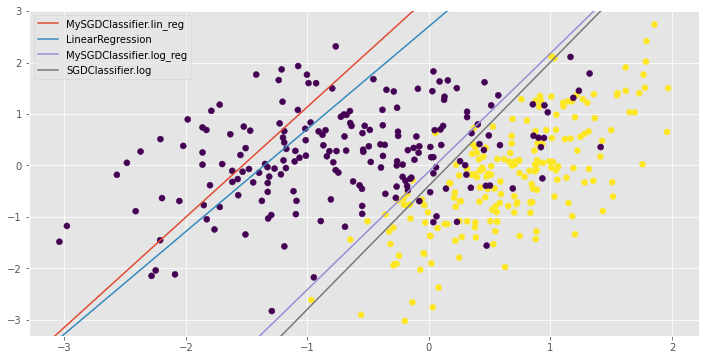

In [10]:
# plot_decision_boundary(your_model)
my_clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', fit_intercept=False).fit(X, y)
my_clf_log = MySGDClassifier(batch_generator, model_type='log_reg', fit_intercept=False).fit(X, y)
clf_lin = LinearRegression(fit_intercept=False).fit(
    np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)), y)
clf_log = SGDClassifier(loss='log', fit_intercept=False).fit(
    np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)), y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plot_decision_boundary(my_clf_lin)
plot_decision_boundary(clf_lin)

plot_decision_boundary(my_clf_log)
plot_decision_boundary(clf_log)
plt.legend()
plt.show()

MySGDClassifier [ 0.          0.31878756 -0.16704981]
LinearRegression [ 0.          0.36884728 -0.18505219]
MySGDClassifier [ 0.          1.17305121 -0.51133426]
SGDClassifier [-1.17958862  4.42588996 -2.32128415]


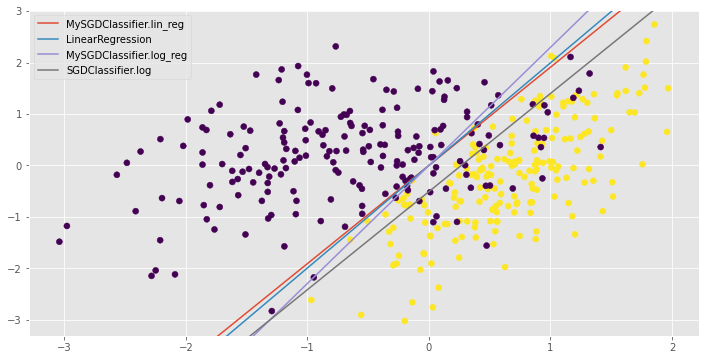

In [11]:
# plot_decision_boundary(your_model)
my_clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg').fit(X, y)
my_clf_log = MySGDClassifier(batch_generator, model_type='log_reg').fit(X, y)
clf_lin = LinearRegression().fit(
    np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)), y)
clf_log = SGDClassifier(loss='log').fit(
    np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)), y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plot_decision_boundary(my_clf_lin)
plot_decision_boundary(clf_lin)

plot_decision_boundary(my_clf_log)
plot_decision_boundary(clf_log)
plt.legend()
plt.show()

В целом, результаты работы моего алгоритма схожи с результатами алгоритмов из sklearn. Здесь главный вопрос - почему `SGDClassifier` с `fit_intercept=True` строит линию не через начало координат.

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [12]:
from sklearn.datasets import make_classification

In [13]:
X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

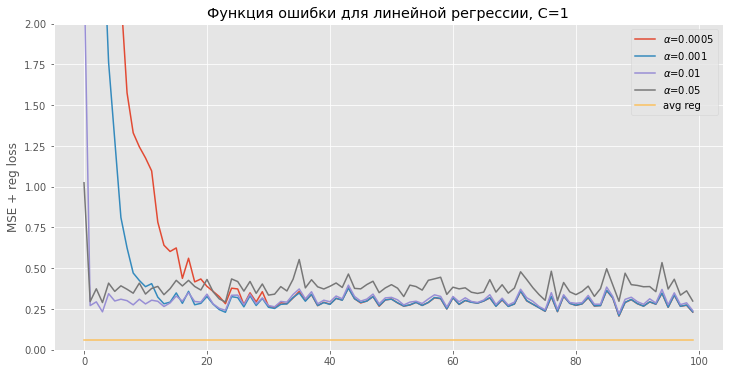

In [14]:
# Your Code Here
N = 100
weights = []
for alpha in [0.0005, 0.001, 0.01, 0.05]:
    clf = MySGDClassifier(batch_generator, alpha=alpha, C=1,
                          max_epoch=1, model_type='lin_reg').fit(X, y)
    loss = np.array(clf.errors_log['loss'])
    plt.plot([loss[i:i + N].mean() for i in range(0, 10000, N)],
             label=f'$\\alpha$={alpha}')
    weights.append(clf.weights)
avg = np.array(weights).mean(axis=0)
plt.plot(np.repeat(np.sum(avg ** 2), 10000 // N), label='avg reg')
plt.legend()
plt.ylabel('MSE + reg loss')
plt.ylim(0, 2)
plt.title('Функция ошибки для линейной регрессии, C=1')
plt.show()

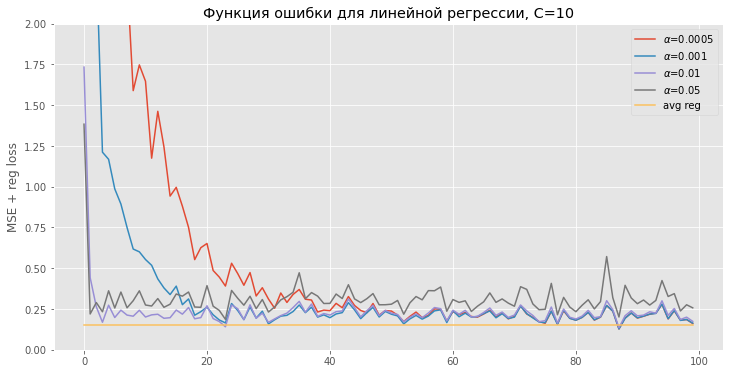

In [15]:
N = 100
weights = []
for alpha in [0.0005, 0.001, 0.01, 0.05]:
    clf = MySGDClassifier(batch_generator, alpha=alpha, C=10,
                          max_epoch=1, model_type='lin_reg').fit(X, y)
    loss = np.array(clf.errors_log['loss'])
    plt.plot([loss[i:i + N].mean() for i in range(0, 10000, N)],
             label=f'$\\alpha$={alpha}')
    weights.append(clf.weights)
avg = np.array(weights).mean(axis=0)
plt.plot(np.repeat(np.sum(avg ** 2), 10000 // N), label='avg reg')
plt.legend()
plt.ylabel('MSE + reg loss')
plt.ylim(0, 2)
plt.title('Функция ошибки для линейной регрессии, C=10')
plt.show()

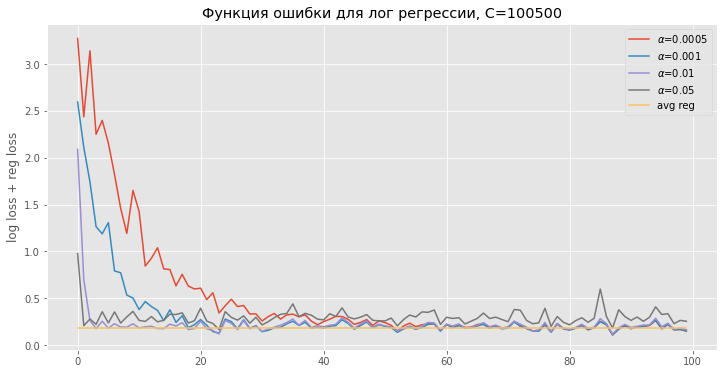

In [16]:
N = 100
weights = []
for alpha in [0.0005, 0.001, 0.01, 0.05]:
    clf = MySGDClassifier(batch_generator, alpha=alpha, C=100500,
                          max_epoch=1, model_type='lin_reg').fit(X, y)
    loss = np.array(clf.errors_log['loss'])
    plt.plot([loss[i:i + N].mean() for i in range(0, 10000, N)],
             label=f'$\\alpha$={alpha}')
    weights.append(clf.weights)
avg = np.array(weights).mean(axis=0)
plt.plot(np.repeat(np.sum(avg ** 2), 10000 // N), label='avg reg')
plt.legend()
plt.ylabel('log loss + reg loss')
plt.title('Функция ошибки для лог регрессии, C=100500')
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Большие $\alpha$ способствуют более быстрой сходимости, но вызывают более заметные колебания вокруг точки минимума.

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

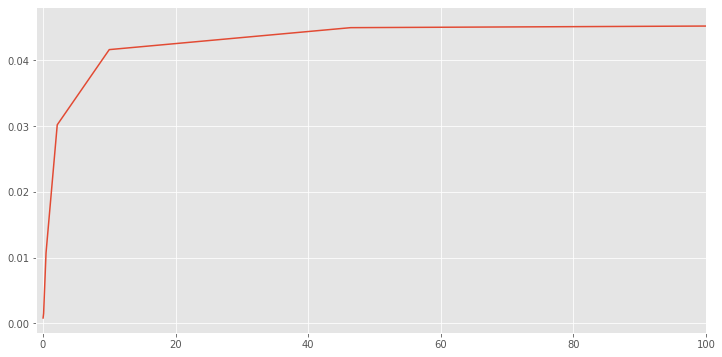

In [17]:
# Your Code Here
warnings.filterwarnings('ignore')
lgspc = np.logspace(3, -3, 10)
weights = np.zeros(len(lgspc))
for i in range(len(lgspc)):
    clf = MySGDClassifier(batch_generator, C=lgspc[i],
                          max_epoch=1, model_type='lin_reg').fit(X, y)
    weights[i] = clf.weights.mean()
plt.xlim(-1, 100)
plt.plot(lgspc, weights)

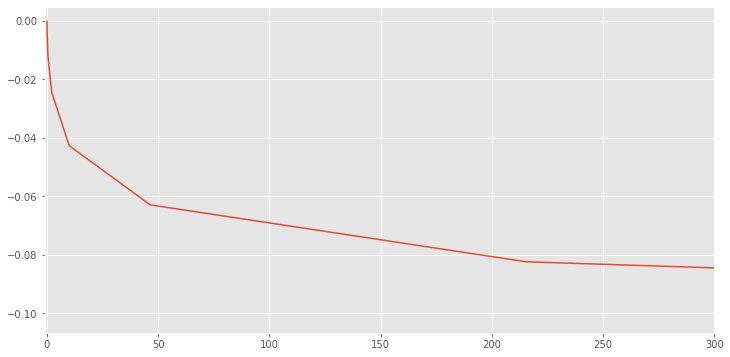

In [18]:
# Your Code Here
lgspc = np.logspace(3, -3, 10)
weights = np.zeros(len(lgspc))
for i in range(len(lgspc)):
    clf = MySGDClassifier(batch_generator, C=lgspc[i],
                          max_epoch=1, model_type='log_reg').fit(X, y)
    weights[i] = clf.weights.mean()
plt.xlim(-1, 300)
plt.plot(lgspc, weights)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

К лету будет в самый раз)

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [19]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [20]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [21]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print(X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [22]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [23]:
skaler = StandardScaler()
X_train = skaler.fit_transform(X_train)

In [24]:
import timeit
for batch_size in [10, 50, 100, 500, 1000]:
    start = timeit.default_timer()
    clf = MySGDClassifier(batch_generator, max_epoch=100, model_type='log_reg',
                          batch_size=batch_size).fit(X_train, y_train)
    print(f'{batch_size}, {timeit.default_timer() - start}')
batch_size = 500

10, 11.535213104999968
50, 2.566075364000028
100, 1.328788258999964
500, 0.4574098909999975
1000, 0.4501525919999949


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [25]:
tot_len = np.unique(groups_train).shape[0]
pcs_len = tot_len // 3
cv = []
for i in range(3):
    f_ind = np.where((i * pcs_len <= groups_train)
                     & (groups_train < (i + 1) * pcs_len))
    t_ind = np.where(np.logical_not((i * pcs_len <= groups_train)
                     & (groups_train < (i + 1) * pcs_len)))
    fold = np.array(f_ind)[0][:, np.newaxis].ravel()
    train = np.array(t_ind)[0][:, np.newaxis].ravel()
    cv.append([train, fold])

In [26]:
def get_score(train, test, **kwargs):
    clf = MySGDClassifier(batch_generator, batch_size=500, **kwargs)
    clf.fit(X_train[train], y_train[train])
    pred = clf.predict(X_train[test])
    if kwargs['model_type'] == 'lin_reg':
        return np.linalg.norm(pred - y_train[test])
    else:
        return -(y_train[test] * np.log(pred)
                 + (1 - y_train[test])*np.log(1-pred)).mean()


top_score = None
top_param = {}
for alpha in [0.001, 0.005, 0.01]:
    for C in np.logspace(1, -1, 10):
        for max_epoch in [1, 5, 10, 15, 25]:
            for model_type in ['lin_reg', 'log_reg']:
                for fit_intercept in (True, False):
                    score = 0
                    for train, test in cv:
                        score += get_score(train, test, alpha=alpha, C=C,
                                           max_epoch=max_epoch,
                                           model_type=model_type,
                                           fit_intercept=fit_intercept)
                    score /= 3
                    if top_score is None or score < top_score:
                        top_score = score
                        top_param = {
                            'alpha':alpha,
                            'C':C,
                            'max_epoch':max_epoch,
                            'model_type':model_type,
                            'fit_intercept':fit_intercept,
                        }
top_param

{'alpha': 0.01,
 'C': 3.5938136638046276,
 'max_epoch': 10,
 'model_type': 'log_reg',
 'fit_intercept': False}

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [27]:
max_score = 0
top_th = 0
for th in np.arange(0.2, 0.8, 0.01):
    score = 0
    for train, test in cv:
        clf = MySGDClassifier(batch_generator, batch_size=500, **top_param)
        clf.fit(X_train[train], y_train[train])
        pred = clf.predict(X_train[test])
        score += f1_score(np.where(pred > th, 1, 0), y_train[test])
    score /= 3
    if score > max_score:
        max_score = score
        top_th = th

In [28]:
top_th, max_score

(0.3100000000000001, 0.610412282283045)

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [29]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id =  new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title, pair_id))

In [30]:
X_test = []
pair_ids = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title, pair_id) in enumerate(docs):
        pair_ids.append(pair_id)
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, pair_id_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
pair_ids = np.array(pair_ids)
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape, pair_ids.shape)

(16627, 15) (16627,) (16627,)


In [31]:
X_test = skaler.transform(X_test)
clf = MySGDClassifier(batch_generator, batch_size=500, **top_param)
clf.fit(X_train, y_train)
pred = np.where(clf.predict(X_test) > top_th, 1, 0)
df = pd.DataFrame({'pair_id': pair_ids, 'target': pred})
df.to_csv('supa_dupa_prediction.csv', index=False)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***